In [1]:
pip install qiskit matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.2 MB/s eta 0:00:00


In [9]:
pip install qiskit-aer

In [12]:
import random
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import Aer
import matplotlib.pyplot as plt

In [13]:
def generate_bits(n):
    return [random.randint(0, 1) for _ in range(n)]

def generate_bases(n):
    return [random.choice(['+', 'x']) for _ in range(n)]

def encode_qubits(bits, bases):
    qubits = []
    for bit, base in zip(bits, bases):
        qc = QuantumCircuit(1, 1)
        if bit == 1:
            qc.x(0)
        if base == 'x':
            qc.h(0)
        qubits.append(qc)
    return qubits


In [19]:
def measure_qubits(qubits, bob_bases):
    backend = Aer.get_backend('qasm_simulator')
    results = []
    for qc, base in zip(qubits, bob_bases):
        circuit = qc.copy()
        if base == 'x':
            circuit.h(0)
        circuit.measure(0, 0)
        job = backend.run(circuit, shots=1, memory=True)
        result = int(job.result().get_memory()[0])
        results.append(result)
    return results

In [15]:
def extract_key(alice_bits, alice_bases, bob_bits, bob_bases):
    key = []
    for i in range(len(alice_bits)):
        if alice_bases[i] == bob_bases[i]:
            key.append(alice_bits[i])
    return key


In [20]:
def intercept(qubits, eve_bases):
    intercepted_qubits = []
    backend = Aer.get_backend('qasm_simulator')
    for qc, base in zip(qubits, eve_bases):
        circuit = qc.copy()
        if base == 'x':
            circuit.h(0)
        circuit.measure(0, 0)
        job = backend.run(circuit, shots=1, memory=True)
        bit = int(job.result().get_memory()[0])

        new_qc = QuantumCircuit(1, 1)
        if bit == 1:
            new_qc.x(0)
        if base == 'x':
            new_qc.h(0)
        intercepted_qubits.append(new_qc)
    return intercepted_qubits

In [17]:
def simulate_bb84(n=100, with_eve=False):
    alice_bits = generate_bits(n)
    alice_bases = generate_bases(n)

    qubits = encode_qubits(alice_bits, alice_bases)

    if with_eve:
        eve_bases = generate_bases(n)
        qubits = intercept(qubits, eve_bases)

    bob_bases = generate_bases(n)
    bob_bits = measure_qubits(qubits, bob_bases)

    # Extract matching key bits
    alice_key = []
    bob_key = []
    for a_bit, a_base, b_bit, b_base in zip(alice_bits, alice_bases, bob_bits, bob_bases):
        if a_base == b_base:
            alice_key.append(a_bit)
            bob_key.append(b_bit)

    # Calculate error rate
    errors = sum([a != b for a, b in zip(alice_key, bob_key)])
    error_rate = errors / len(alice_key) * 100 if alice_key else 0

    print("Alice's Key:", alice_key)
    print("Bob's Key:  ", bob_key)
    print("Error Rate:", error_rate, "%")

    return error_rate


Alice's Key: [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Bob's Key:   [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Error Rate: 0.0 %
Alice's Key: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0]
Bob's Key:   [1, 1, 1, 0, 1, 0, 1, 1,

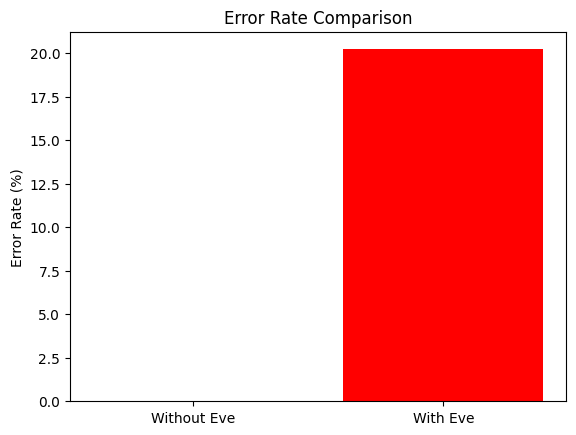

In [21]:
normal_error = simulate_bb84(200, with_eve=False)
eavesdropped_error = simulate_bb84(200, with_eve=True)

labels = ['Without Eve', 'With Eve']
errors = [normal_error, eavesdropped_error]

plt.bar(labels, errors, color=['green', 'red'])
plt.title('Error Rate Comparison')
plt.ylabel('Error Rate (%)')
plt.show()
